# Intro
Let's begin with an example: Suppose we want to predict whether a particular sequence of DNA has a binding site for a transcription factor (TF) of your interest or not. Using the traditional approach, we would use a positional weight matrix (PWF) to scan the sequence and identify the potential motifs that are overrepresented. Using an ML-based approach, we would give an ML model plenty of DNA sequences until the ML model learns the mathematical relationship between the features from those DNA sequences that either have or don’t have binding sites (labels) based on experimental results.

## Sequencing techniques
* First-generation DNA sequencing: Sanger sequencing
* Second-generation DNA sequencing: Illumina sequencing by synthesis (SBS) technology. The typical size of generated fragments are in the range of 50-300 bases.
* Third-generation DNA sequencing: Illumina Pacific Bioscience single-molecule sequencing real-time (SMRT) and Oxford Nanopore Technologies nanopore sequencing. The typical size of generated fragments are in the range of 15000 bases.

## Cloud computing for genomics data analysis
* Amazon Web Services (AWS)
* Azure
* Google Cloud Platform (GCP)

# Biopython
## Seq object
It essentially combines a Python string with biological methods such as DNA, RNA, or protein:

In [1]:
# Create Seq object
from Bio.Seq import Seq

my_seq = Seq("AGTAGGACAGAT")

In [2]:
# Print Seq object
print(my_seq)

AGTAGGACAGAT


In [3]:
# Return the complement of the Seq object
print(my_seq.complement())

TCATCCTGTCTA


## SeqRecord object
This object differs from the Seq object in that it holds a sequence (as a Seq object) with additional information such as identifier, name, and description.

In [4]:
# Create SeqRecord object
from Bio.SeqRecord import SeqRecord

my_seqrecord = SeqRecord(
    Seq("AGTAGGACAGAT"),
    id="ENSG00000121966",
    name="Gene1",
    description="A sample gene",
)

In [5]:
# Print SeqRecord object
print(my_seqrecord)

ID: ENSG00000121966
Name: Gene1
Description: A sample gene
Number of features: 0
Seq('AGTAGGACAGAT')


## SeqIO object
The SeqIO object in Biopython provides the standard sequence input/output interface. It supports several file formats as input and output including FASTA, FASTQ, and GenBank (GB).

# Use case – Sequence analysis of Covid-19

First let's import (parse) the FASTA file:

In [6]:
# Parse file
from Bio import SeqIO

with open("Data/covid19.fasta") as file:
    for record in SeqIO.parse(file, "fasta"):
        print(f'Sequence information: \n{record}')
        print(f'Sequence length: {len(record)}')

Sequence information: 
ID: NC_045512.2
Name: NC_045512.2
Description: NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
Number of features: 0
Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA')
Sequence length: 29903


## Calculate GC content

Now let's calculate its GC content. GC content is one of the important features of a DNA sequence as it is an important predictor of gene function and species ecology. GC content is calculated by counting the number of Gs and Cs in the sequence and dividing that by the total sequence length.

In [7]:
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction

with open("Data/covid19.fasta") as file:
    for record in SeqIO.parse(file, "fasta"):
        gc_content = gc_fraction(record)
        print(f'GC content: {round(gc_content, 2)}')

GC content: 0.38


## Calculate nucleotide content

Nucleotide content such as the percentages of A, T, C, and G are useful for sequence characterization purposes.

In [8]:
from Bio import SeqIO

with open("Data/covid19.fasta") as file:
    for record in SeqIO.parse(file, "fasta"):
        seq_record = record.seq
        seq_length = len(record.seq)
        print(f'{round(seq_record.count("T") / seq_length * 100, 1)}% T')
        print(f'{round(seq_record.count("A") / seq_length * 100, 1)}% A')
        print(f'{round(seq_record.count("C") / seq_length * 100, 1)}% C')
        print(f'{round(seq_record.count("G") / seq_length * 100, 1)}% G')

32.1% T
29.9% A
18.4% C
19.6% G


## Calculate dinucleotide content

It’s also valuable to count the dinucleotides (AT, AC, GT, and so on).

In [9]:
from Bio import SeqIO

nucl = ['A', 'T', 'C', 'G']
di_nucl_dict = {}
with open("Data/covid19.fasta") as file:
    for record in SeqIO.parse(file, "fasta"):
        for n1 in nucl:
            for n2 in nucl:
                di = str(n1) + str(n2)
                di_nucl_dict[di] = record.seq.count(di)

print(di_nucl_dict)

{'AA': 2169, 'AT': 2308, 'AC': 2023, 'AG': 1742, 'TA': 2377, 'TT': 2454, 'TC': 1413, 'TG': 2589, 'CA': 2084, 'CT': 2081, 'CC': 784, 'CG': 439, 'GA': 1612, 'GT': 1990, 'GC': 1168, 'GG': 973}


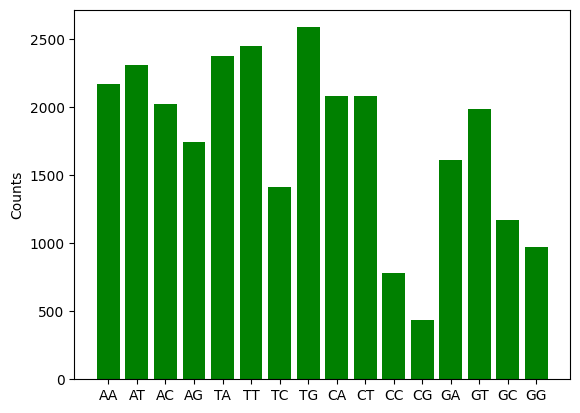

In [10]:
# Generate a dinucleotide plot
import matplotlib.pyplot as plt

di = [k for k, v in di_nucl_dict.items()]
counts = [v for k, v in di_nucl_dict.items()]
plt.bar(di,counts, color = "green")
plt.ylabel("Counts")
plt.show()

## Save features

Let's save all the features that we have extracted so far into a file and get it ready for modeling.

In [11]:
# Extract all features
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import pandas as pd

nucl = ['A', 'T', 'C', 'G']
features = {}

with open('Data/covid19.fasta') as file:
    for record in SeqIO.parse(file, "fasta"):
        for n1 in nucl:
            for n2 in nucl:
                di = str(n1) + str(n2)
                features[di] = record.seq.count(di)
            A_count = record.seq.count('A')
            features['A_count'] = round(A_count / len(record) * 100, 2)
            C_count = record.seq.count('C')
            features['C_count'] = round(C_count / len(record) * 100, 2)
            G_count = record.seq.count('G')
            features['G_count'] = round(G_count / len(record) * 100, 2)
            T_count = record.seq.count('T')
            features['T_count'] = round(T_count / len(record) * 100, 2)
            features['GC_content'] = round(gc_fraction(record), 2)
            features['Size'] = len(record)

# Create a dataframe
features_df = pd.DataFrame.from_dict([features])
features_df['virus'] = "Covid19"

# Save features into a sile
features_df.to_csv("Output/covid19_features.csv", index = None)

# Check the output file
features = pd.read_csv("Output/covid19_features.csv")
features

,AA,AT,AC,AG,A_count,C_count,G_count,T_count,GC_content,Size,...,TG,CA,CT,CC,CG,GA,GT,GC,GG,virus
0,2169,2308,2023,1742,29.94,18.37,19.61,32.08,0.38,29903,...,2589,2084,2081,784,439,1612,1990,1168,973,Covid19


# Motif finder

A motif is a pattern in a nucleotide or amino acid sequence that has a specific structure. Sequence motifs play a key role in gene expression regulating both transcriptional and post-transcriptional levels.

In [12]:
from Bio import motifs
from Bio.Seq import Seq

# Create a DNA motif Seq object
my_motif = [Seq("ACGT"), Seq("TCGA"), Seq("CGGC")]

# Convert Seq object to motif object
motifs = motifs.create(my_motif)
print(motifs)

ACGT
TCGA
CGGC



Let's print the counts of each nucleotide at each position. This can also refer as the position frequency matrix (PFM).

In [13]:
print(motifs.counts)

        0      1      2      3
A:   1.00   0.00   0.00   1.00
C:   1.00   2.00   0.00   1.00
G:   0.00   1.00   3.00   0.00
T:   1.00   0.00   0.00   1.00



Now create a logo from the motifs:

In [ ]:
motifs.weblogo('Output/my_motif.png')

# Clear redundant files

In [15]:
import os
from pathlib import Path
file1 = "Output/my_motif.png"
file2 = "Output/covid19_features.csv"

# If file exists, delete it
if os.path.isfile(file1):
    os.remove(file1)

if os.path.isfile(file2):
    os.remove(file2)